# Captcha Recognition

Using Keras and some interesting tools of image noise reduction in OpenCV, we aim to break CAPTCHA images from around 2007 using a CNN! This should be a fun little project involving some cool techniques...

The dataset, containing 1070 images, can be found [here](https://www.kaggle.com/fournierp/captcha-version-2-images).

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
import torch
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.models import Model,Sequential, Input, load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D

# Data & Noise Removal

In [2]:
data_dir = "captcha/samples"
images = os.listdir(data_dir)
images[1]

'22d5n.png'

Let us check some images & then perform some necessary noise removal.

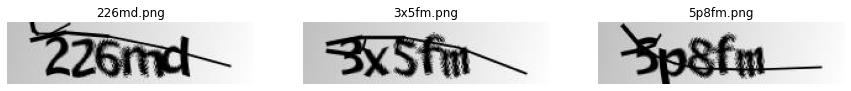

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(cv2.imread(os.path.join(data_dir, images[100*i])))
    ax[i].set_title(images[100*i])

As we can see, there is a thin black line going through the images to obscure the characters. To remove this noise, we can use erosion and dilation. The basic principle is that we first 'erode' away the line (the noise) and then 'dilate' the image to recover the 'non-noise' lost in the erosion stage. Lets see an example

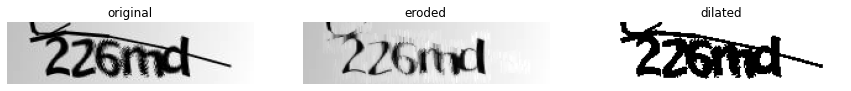

In [4]:
## Specify the path and convert to array with 'imread'. 

img_path = os.path.join(data_dir, images[0])
img = cv2.imread(img_path, 0)

## Adaptive thresholding works by deciding if pixels are 'on' or 'off' based on whether they exceed a locally calculated
## threshold. In this case, the threshold of an area is the mean of 201 local pixels, minus constant 15.

kernel = np.ones((5,1), np.uint8)
img_eroded = cv2.dilate(img, kernel, iterations=1)
img_dilated = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 201, 15)

compare, caption = [img, img_eroded, img_dilated], ['original', 'eroded', 'dilated']

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(compare[i], 'gray')
    ax[i].set_title(caption[i])

Hopefully, we can combine erosion and dilation, and see the line vanish, without negatively impacting the visibility of other characters!

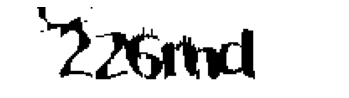

In [5]:
test = cv2.adaptiveThreshold(img_eroded, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 71, 13)

plt.imshow(test, 'gray')
plt.axis('off');

After some experimentation, these parameters seem to work reasonably well. This step can be experimented with & further optimised for better results. Lets define a function that applies both transformations.

In [6]:
def processor(img_path):
    img = cv2.imread(str(img_path), 0)
    kernel = np.ones((5,1), np.uint8)
    test = cv2.dilate(img, kernel, iterations=1)
    newtest = cv2.adaptiveThreshold(test,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,71,13)
    return newtest

Now we must split each image into its constituent characters and label each image. Unfortunately, due to the non-uniform nature of how the characters are spread image-to-image, this is quite difficult. In particular, the character 'm' is much wider than other characters, and can cause each proceeding character to be displaced from expected position...

In [7]:
X, y = [], []
for img in images:
    temp = processor(os.path.join(data_dir, img))
    for i in range(5):
        X.append(temp[:,(29+23*i):(29+23*(i+1))])
        y.append(img[i])
        
X = np.array(X, dtype='float')
X /= 255
X = X.reshape(-1,50,23,1)

Have 1070 images each with 5 characters, so we expect 5350 rank-3 arrays. Height and width are 50 and 23 respectively, and we force this into a rank 4 array which would represent RGB if we were working in colour.

In [8]:
X.shape

(5350, 50, 23, 1)

Check to see everything worked...

'2'

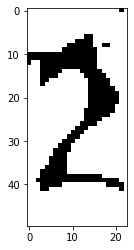

In [9]:
plt.imshow(X[0], 'gray');
y[0]

Convert labels in y to 'one-hot encoding' format, first by making a list of integer encodings

In [10]:
train = []
chars = ['2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y']
y_cat = [chars.index(y[i]) for i in range(len(y))]
y_cat = to_categorical(y_cat, num_classes=19)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state = 42)

# CNN Building

Apply augmentation to diversify training data. Most options are unnecassary, since our data is not too varied. For instance, since our pixels are 'on' or 'off', augmenting brightness is not helpful. Similairly, applying flips or rescales are not needed since the images are quite uniform.

In [12]:
datagen = ImageDataGenerator(rotation_range=5, # Degree range for random rotations
                        width_shift_range=0.1, # Range for random horizontal shifts
                        height_shift_range=0.1, # Range for random vertical shifts
                        zoom_range=0.1, # Range for random zoom
                        ) 

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', padding = 'Same', input_shape=(50, 23, 1)))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), padding = 'Same', activation='relu'))

model.add(layers.Conv2D(32, (3, 3), padding = 'Same', activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), padding = 'Same', activation='relu'))

model.add(layers.Conv2D(64, (3, 3), padding = 'Same', activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), padding = 'Same', activation='relu'))

model.add(layers.Conv2D(64, (3, 3), padding = 'Same', activation='relu'))
model.add(layers.MaxPool2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(19, activation='softmax'))

In [14]:
EPOCHS = 30
BATCH_SIZE = 64

In [15]:
optimizer = Adam(lr=0.001)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
annealer = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                              steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=[annealer],
                              validation_data=(X_val, y_val))

C:\Users\jguze\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
66/66 [==============================] - 8s 104ms/step - loss: 2.9377 - accuracy: 0.0864 - val_loss: 2.8041 - val_accuracy: 0.1009
Epoch 2/30
66/66 [==============================] - 5s 71ms/step - loss: 2.5948 - accuracy: 0.1711 - val_loss: 1.2606 - val_accuracy: 0.6449
Epoch 3/30
66/66 [==============================] - 5s 72ms/step - loss: 1.5692 - accuracy: 0.5169 - val_loss: 0.7466 - val_accuracy: 0.7617
Epoch 4/30
66/66 [==============================] - 5s 72ms/step - loss: 0.9570 - accuracy: 0.7080 - val_loss: 0.4951 - val_accuracy: 0.8617
Epoch 5/30
66/66 [==============================] - 5s 72ms/step - loss: 0.7031 - accuracy: 0.7736 - val_loss: 0.3990 - val_accuracy: 0.8841
Epoch 6/30
66/66 [==============================] - 5s 72ms/step - loss: 0.5848 - accuracy: 0.8222 - val_loss: 0.3866 - val_accuracy: 0.8841
Epoch 7/30
66/66 [==============================] - 5s 73ms/step - loss: 0.4810 - accuracy: 0.8514 - val_loss: 0.3756 - val_accuracy: 0.8991
Epoch 8/30
6

Our model identifies individual characters with ~95.4% accuracy! However, a CAPTCHA is not broken unless all 5 contained characters are correct, so we need to calculate accuracy based on complete 'validation set' images.

<hr style="border:2px solid gray"> </hr>

### Aside: Interpreting the Model

This is somewhat unspecific to this example, but as a 'sanity check' let us interpret one prediction from our model to ensure we have a solid understanding of what is going on here...

In [16]:
X_example = X_val[0:1,:,:,:]

f"X_val has shape: {X_val.shape}", \
f"X_example has shape: {X_example.shape}"

('X_val has shape: (1070, 50, 23, 1)', 'X_example has shape: (1, 50, 23, 1)')

In [17]:
ex_prediction = model.predict(X_example)
ex_prediction

array([[1.08303034e-07, 4.01050215e-09, 3.52262086e-09, 1.25468731e-07,
        7.54163693e-06, 3.24091021e-09, 9.52213156e-07, 3.13781605e-08,
        3.85722672e-07, 1.65440341e-07, 9.60223474e-07, 1.25913303e-07,
        5.55118369e-08, 3.50186788e-02, 1.27968829e-04, 5.53077584e-08,
        9.64837193e-01, 5.28299233e-06, 3.73411240e-07]], dtype=float32)

Due to our final activation being the softmax function, we can interpret this array as the likelihood of the first character of X_val being each of the characters specified by the one-hot encoding. In other words, our model predicts the first character of X_val is the character '2' with probability 1.08303034e-07, and so on. Thus, we can round to obtain a definitive prediction.

In [18]:
np.round(ex_prediction)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0.]], dtype=float32)

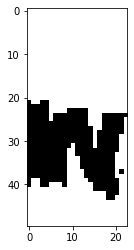

In [19]:
plt.imshow(X_example[0,:,:,:], 'gray');

In [20]:
f"Label of first character is: {chars[np.argmax(y_val[0])]}", \
f"Predicted label is: {chars[np.argmax(np.round(ex_prediction))]}"

('Label of first character is: w', 'Predicted label is: w')

<hr style="border:2px solid gray"> </hr>

# Model Analysis

Lets create a confusion matrix to see the most commonly misidentified characters...

In [21]:
predictions = model.predict(X_val).argmax(axis=1)
y_val_int = y_val.argmax(axis=1)

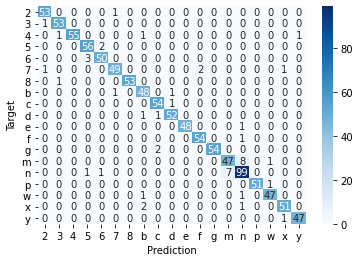

In [22]:
ax= plt.subplot()
conf = confusion_matrix(y_val_int, predictions)
sns.heatmap(conf, annot=True, cmap='Blues')
ax.xaxis.set_ticklabels(chars)
ax.yaxis.set_ticklabels(chars)
plt.xlabel("Prediction")
plt.ylabel("Target");

As expected, the most commonly confused characters are 'n' and 'm'. This can be attributed to the selected window size being generally too small for 'm', thus making 'm' look like 'n' in training. We can specify indexes of wrongly predicted characters as follows.

In [26]:
errors_index = [i for i,pred in enumerate(predictions) if pred!=y_val_int[i]]
errors_preds_nm = [i for i in errors_index if chars[y_val_int[i]] in ('n','m') and chars[predictions[i]] in ('n','m')]

We can perform a quick and rough check to see if we've made a mistake. We hope the following value returns our validation accuracy of 95.4%. We can also check what proportion of our errors confuse n and m...

In [29]:
acc = (len(y_val)-len(errors_index))/len(y_val)*100
nm_percentage = (len(errors_preds_nm)/len(errors_index))*100

f"Accuracy is: {round(acc, 3)} %", \
f"Proportion of misses from 'n, m' confusion is: {round(nm_percentage, 3)} %"

('Accuracy is: 95.421 %',
 "Proportion of misses from 'n, m' confusion is: 30.612 %")

Lets view a few wrongly identified characters and their respective target labels...

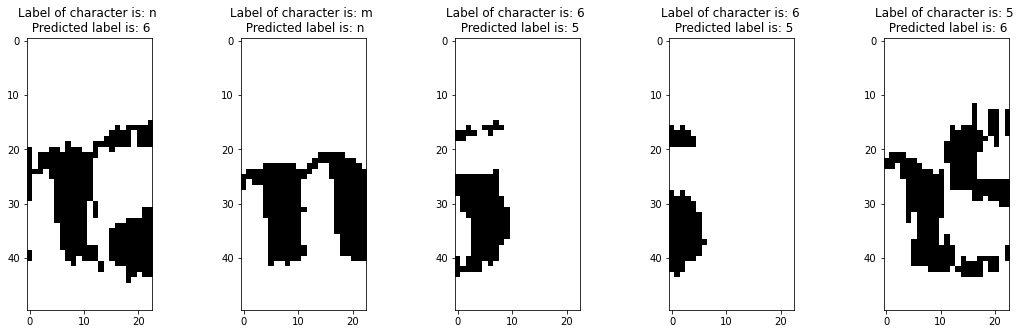

In [30]:
nl='\n'
fig, ax = plt.subplots(1, 5, figsize=(5, 5))
plt.subplots_adjust(right=3)

for i in range(5):
    ax[i].imshow(X_val[errors_index[2*i]],'gray')
    ax[i].set_title(f"Label of character is: {chars[y_val_int[errors_index[2*i]]]} {nl} Predicted label is: {chars[predictions[errors_index[2*i]]]}")

It's clear that many of our errors are arising from badly spaced 'windows' around characters. This is somewhat hard to combat since it's hard to identify where one character ends and another begins. One way to approach this would be to build a model that identifies the character window boundry x co-ordinates, but this would take lots data labellling to train such a model.

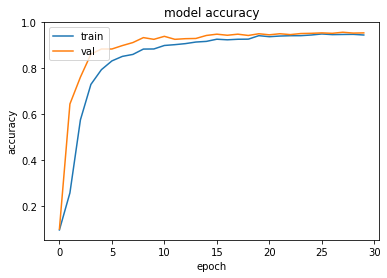

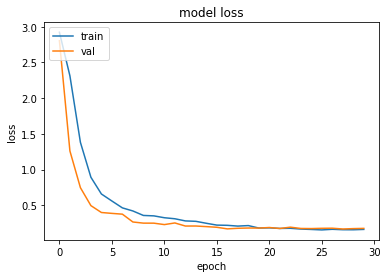

In [31]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Analysis on Full CAPTHCA Images

Now, lets use our character-based model to make predictions on full CAPTCHA images. As input, pass the image path. The function will print the prediction, and return 1 if correct, else 0.

In [32]:
def CAPTCHA(img_path, pr):
    img = processor(img_path)
    prediction = ''
    characters = []
    for i in range(5):
        characters.append(img[:,(29+23*i):(29+23*(i+1))])
    characters = np.reshape(characters, (-1,50,23,1))
    predictions = model.predict(characters)
    predictions = np.argmax(predictions ,axis = 1)
    for i in range(5):
        prediction+=chars[predictions[i]]
    if pr==True:
        print(prediction)
    if prediction==img_path[-9:-4]:
        return 1
    return 0

In [33]:
num_correct = sum([CAPTCHA(os.path.join(data_dir, image), False) for image in images])

In [34]:
f"Final accuracy: {num_correct/len(images) * 100} %"

'Final accuracy: 82.14953271028037 %'